In [222]:
import pandas as pd
import sklearn.feature_selection as fs
import sklearn.metrics
import pyreadr
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import shap
import xgboost
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

In [223]:
shap.initjs()

In [224]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [225]:
%%R
# Read Classification dataset from RDS
model_data = readRDS("KDEN_Class_Data.RDS")

In [226]:
%R -o model_data

In [227]:
model_data

,FLIGHTCOUNT,STRIKE,BIRDCOUNT,TEMP,SLP,WANGLE,WSPEED,COVER,CLOUDH,COVERH,PRECIP,VIS,YEAR,MONTH,DAY,SEASON
1,77.0,NO,4.0,19.199330,10229.596315,102.361809,33.453936,2.994975,1638.190955,1311.504188,0.000000,16000.000000,1995,04,Saturday,spring
2,58.0,NO,4.0,34.125090,10213.817064,277.798265,31.036153,2.989877,5250.657628,1450.795915,0.019523,15340.046999,1995,04,Sunday,spring
3,81.0,NO,2882.0,60.447368,10174.961988,179.444444,49.792398,2.994152,9001.660819,2065.438596,0.000000,16000.000000,1995,05,Wednesday,spring
4,81.0,NO,1788.0,97.598837,9936.159884,225.872093,23.165698,2.595930,15278.406977,3050.328488,0.000000,15427.906977,1995,05,Friday,spring
5,2.0,NO,52.0,147.833333,9929.166667,130.000000,53.000000,2.333333,8864.333333,2474.166667,0.000000,16046.500000,1995,05,Saturday,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,99.0,NO,1387.0,-54.746345,10104.442982,151.842105,59.192251,1.548246,13519.119883,1165.817251,0.000000,16078.621711,2018,12,Thursday,winter
5607,98.0,NO,3534.0,-91.725385,10218.854615,63.461538,31.592692,2.093077,4541.463846,1260.404615,0.000000,15962.871538,2018,12,Friday,winter
5608,85.0,NO,3107.0,-74.079570,10219.427957,173.655914,29.430108,1.466667,15514.681720,3585.088172,0.000000,15371.138710,2018,12,Saturday,winter
5609,96.0,NO,2850.0,43.213531,10054.292812,185.412262,47.271670,1.000000,19199.729387,4317.116279,0.000000,16079.630021,2018,12,Sunday,winter


In [228]:
model_data = pd.get_dummies(model_data,
                            columns=['DAY', 'SEASON'])

In [238]:
Y = (model_data['STRIKE'] == "YES")
# y = (data['Man of the Match'] == "Yes")
# Y = model_data['STRIKE']
X = model_data[model_data.columns.difference(['STRIKE', 'COVERH', 'COVER', 'CLOUDH', 'TEMP', 'WANGLE', 'MONTH', 'YEAR'])]

X_display,y_display = shap.datasets.adult(display=True)

In [239]:
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
d_train = xgboost.DMatrix(X_train, label=Y_train)
d_test = xgboost.DMatrix(X_test, label=Y_test)

In [240]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100 * np.sum(f(X_test) == Y_test) /
                                   len(Y_test)))
    time.sleep(0.5)  # to let the print get out before any progress bars

In [241]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(Y_train),
    "eval_metric": "logloss"
}
xgb_model = xgboost.train(params,
                          d_train,
                          5000,
                          evals=[(d_test, "test")],
                          verbose_eval=100,
                          early_stopping_rounds=20)

[0]	test-logloss:0.492885
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.466757
[200]	test-logloss:0.459282
[300]	test-logloss:0.456004
Stopping. Best iteration:
[303]	test-logloss:0.455951



In [242]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(d_test)

In [243]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[121,:], X_test.iloc[121,:])

In [244]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:200,:], X_test.iloc[:200,:])

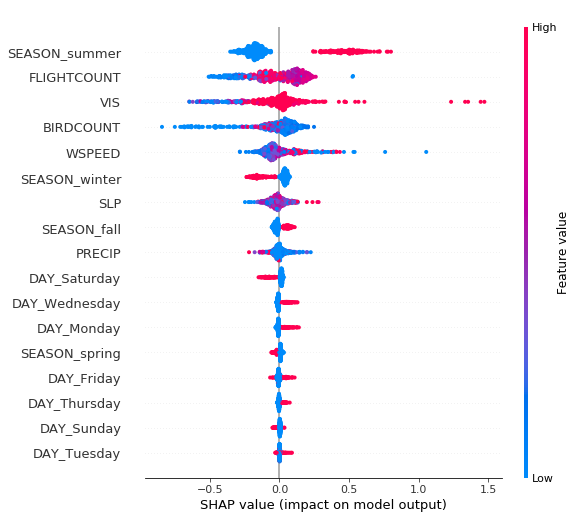

In [245]:
shap.summary_plot(shap_values_xgb, X_test)

In [246]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(X_train, Y_train)

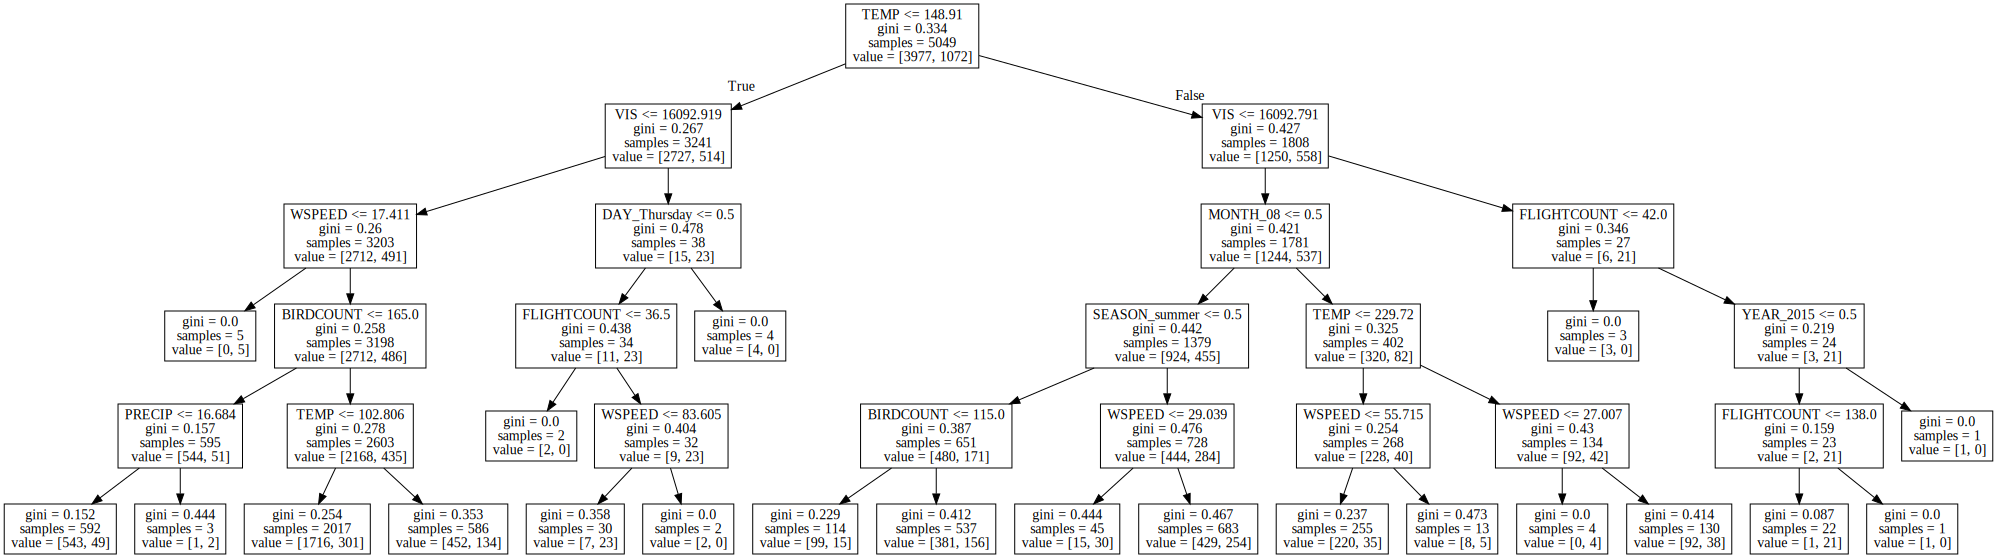

In [219]:
feature_names = [i for i in X_train.columns]

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph, directory="tree.png")




dotfile = StringIO.StringIO()
tree.export_graphviz(dectree, out_file=dotfile)
graph=pydotplus.graph_from_dot_data(dotfile.getvalue())
graph.write_png("dtree.png")

In [178]:
rf_model = RandomForestClassifier(max_depth=6,
                                  random_state=0,
                                  n_estimators=12,
                                  min_samples_split=2)

In [180]:
rf_model.fit(X_train, Y_train)
print_accuracy(rf_model.predict)

Accuracy = 79.67914438502673%


[7.22947311e-02 2.04620118e-01 2.39751158e-03 3.85170989e-03
 6.81046839e-03 2.72736241e-03 5.14339077e-03 4.51544699e-03
 1.83964002e-03 2.79101697e-02 1.26181866e-03 1.15077166e-02
 6.07980200e-03 1.44129782e-02 7.21169646e-03 3.50119769e-02
 1.18722856e-02 2.57759870e-03 9.17484784e-03 1.36850715e-03
 2.46102956e-06 1.51550887e-03 3.10358681e-02 1.08368396e-02
 2.92542643e-03 8.99392922e-02 3.87310167e-02 3.72810732e-02
 1.43371845e-01 8.00255269e-02 4.45523205e-02 1.83789446e-03
 1.55255257e-02 2.03374263e-04 3.22593100e-04 1.64406341e-03
 1.95402812e-03 1.24704065e-03 2.65354830e-03 6.49284250e-04
 6.82066664e-04 1.83604879e-03 2.56641724e-03 4.56952634e-03
 2.32870895e-03 2.92564542e-03 1.47068924e-03 2.88248426e-03
 3.02975269e-03 0.00000000e+00 9.48058079e-03 1.28208445e-02
 1.50295744e-02 7.98354654e-04 7.34998972e-04 0.00000000e+00]


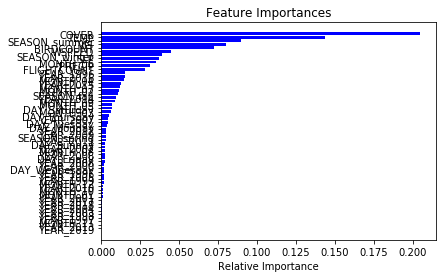

In [52]:
print(rf_model.feature_importances_)
importances = rf_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [195]:
X_train_summary = shap.kmeans(X_train, 10)

In [196]:
# rf_shap_values = shap.KernelExplainer(rf.predict,X_test)
# rf_shap_values

# explain all the predictions in the test set
explainer = shap.TreeExplainer(rf.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Exception: Model type not yet supported by TreeExplainer: <class 'method'>

In [145]:
i = 1
shap.force_plot(explainer.expected_value,
                shap_values[1][i],
                X_train[i],
                feature_names=feature_names)

# shap.force_plot(base_value=explainer.expected_value[1], shap_values=shap_values[1][i],
#                 features=X_train[i], feature_names=feature_names)

KeyError: 1

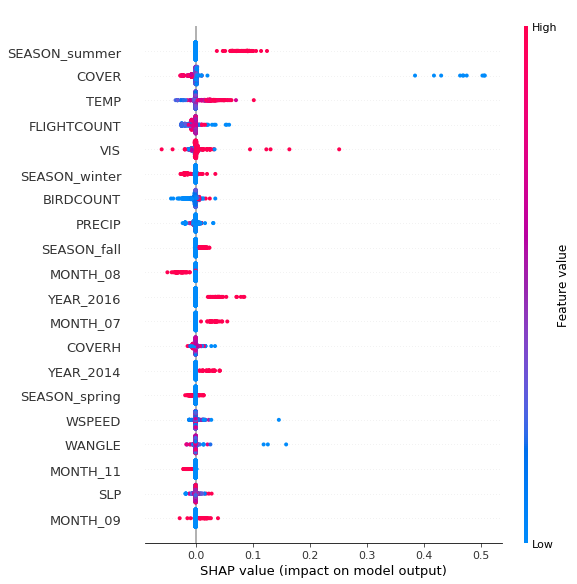

In [186]:
shap.summary_plot(shap_values[1], X_test)

Could not find feature named: STRIKE


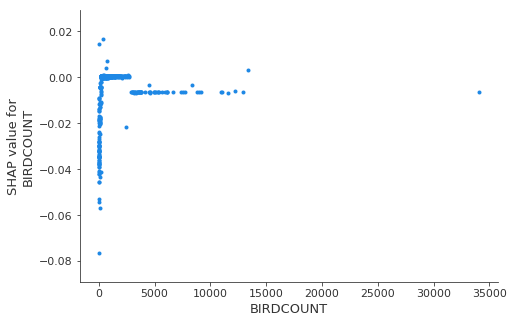

In [138]:
shap.dependence_plot('BIRDCOUNT',
                     shap_values[1],
                     X_test,
                     interaction_index="STRIKE")

Could not find feature named: BIRDCOUNT %
Could not find feature named: STRIKE


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

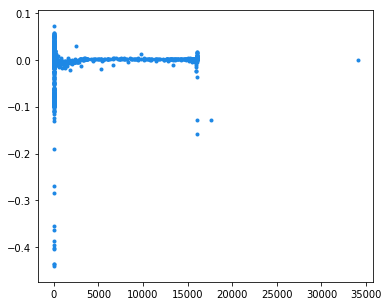

In [142]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)

# make plot.
shap.dependence_plot('BIRDCOUNT %',
                     shap_values[0],
                     X_test,
                     interaction_index="STRIKE")